In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docutils.nodes import figure

# Time Value of Money Under Uncertainty
## A Monte Carlo Approach Using Probability Theory and Numerical Simulation
## Scientific Method Approach

# 1. Observation

In classical financial theory, the Net Present Value (NPV) of a project is computed using deterministic future cash flow.

However, in real-world financial planning and analysis, future cash flow are uncertain and depend on economic conditions, demand variability and operation performance.

This raises the question: how should project valuation change when cash flow are random?


## 2. Research Question

If future cash flows are random variables instead of fixed numbers,
how does this affect the mathematical nature of Net Present Value ( NPV ) ?

Specifically:

* Does NPV become random variable
* What are its expected value variance?
* How can we approximate its distribution using simulation?

## 3. Hypothesis

If each cash flow $$ ( CF_t ) $$ is modeled as a random variable, then:

$$ NPV = \sum_{t=0}^{T} \frac{CF_t}{(1+r)^t} $$

is a linear combination of random variables.

Therefore:

• NPV is itself a random variable.
• It has a well-defined expected value.
• It has a measurable variance (risk).
• Its distribution can be approximated numerically using Monte Carlo simulation.

## 4. Deterministic Mathematical Model

In classical Time Value of Money, capital grows exponentially under compound interest.

If an initial investment $( P )$ grows at rate $(r)$ for $(t)$ periods:

$$ FV = P(1+r)^t $$

Solving for present value:

$$ PV = \frac{FV}{(1+r)^t} $$

Thus, discounting is the inverse operation of exponential growth

### Implementation Strategy and Numerical Example

The deterministic formulas derived above are now implemented in Python
These function will later serve as the core building blocks for the [stochastic extention.](https://en.wikipedia.org/wiki/Stochastic_process)

We verify the deterministic TVM formulas using a simple example.

* Initial Investment: 1000
* Interest Rate: 3%
* Time Horizon: 3 years

In [17]:
def future_value(p, r, t):
    return p * (1+r) ** t

def present_value(fv, r, t):
    return fv / (1+r) ** t

p = 1000
r = 0.05
t = 3

FV = future_value(p,r,t)
PV = present_value(FV, r, t)
PV_recovered = present_value(FV, r, t)

print("Future Value: ", FV)
print("Present Value: ", PV)
print("Recovered Value: ", PV_recovered)
print("Numerical Error:", abs(PV - PV_recovered))


Future Value:  1157.6250000000002
Present Value:  1000.0000000000001
Recovered Value:  1000.0000000000001
Numerical Error: 0.0


### Exponential Growth Visualization

To build intuition for compound interest, we visualize the future value function:

$$ FV(t) = P(1+r)^t $$

This function represents exponential growth. Unlike linear growth, the rate of increase accelerates over time because interest is earned on accumulated interest.

Understanding this curvature is important before introduction uncertainty, since longer time horizons amplify both expected returns and potential risk.

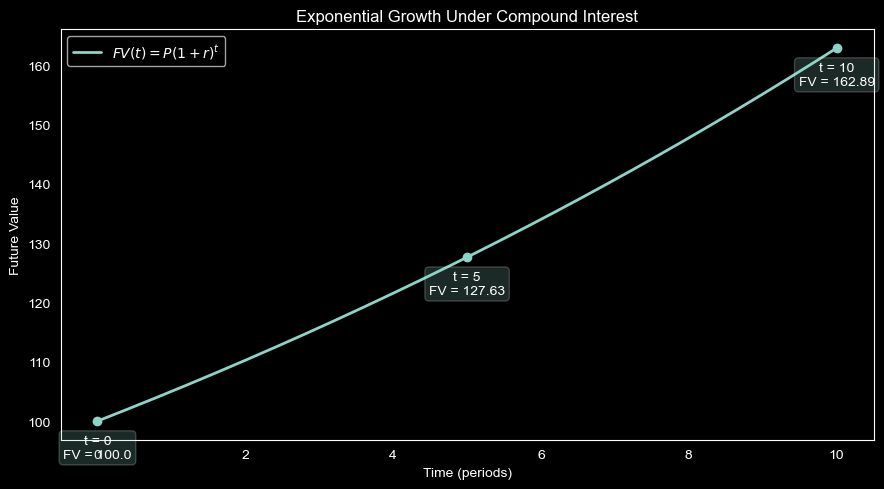

In [18]:
t_values = np.linspace(0, 10, 200)
P = 100
r = 0.05

growth = future_value(P, r, t_values)

plt.figure(figsize=(9, 5))
plt.plot(t_values, growth, linewidth=2, label=r"$FV(t)=P(1+r)^t$")

# Highlight a few key points for intuition
key_t = np.array([0, 5, 10])
key_fv = future_value(P, r, key_t)
plt.scatter(key_t, key_fv, zorder=3)

for i in range(len(key_t)):
    tt = key_t[i]
    ff = key_fv[i]

    plt.annotate(
        "t = " + str(tt) + "\nFV = " + str(round(ff, 2)),
        xy=(tt, ff),
        xytext=(0, -10),   # move text below point
        textcoords="offset points",
        ha="center",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.2)
    )

plt.title("Exponential Growth Under Compound Interest")
plt.xlabel("Time (periods)")
plt.ylabel("Future Value")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.grid(None)
plt.show()

## 5. Stochastic Cash Flows (Triangular Model)

In practise, future cash flows are uncertain.
Instead of assuming single deterministic value for each period, we model cash flows as random variables.

In financial planning and analysis a common assumption is the **triangular distribution**, defined by:

* Minimum value ( worst case )
* Most likely value ( base case )
* Maximum value ( best case )

This distribution reflects managerial forecast more realistically than assuming symmetrical normal uncertainty.

The triangular distribution is especially useful when:

* Historical data is limited
* Expert judgment is available
* Forecast ranges are defined

This makes it suitable for capital budgeting applications.

Let the cash flow in period $(t)$ follow:

$$ CF_t \sim Triangular(a_t, m_t, b_t) $$

where:
- $(a_t)$ = minimum
- $(m_t)$ = most likely
- $(b_t)$ = maximum

Since NPV is a weighted sum of these random variables:

$$ NPV = \sum_{t=0}^{T} \frac{CF_t}{(1+r)^t} $$

Net Present Value (NPV) becomes variable itself.

### Deterministic NPV Function

We implement a reusable function for computing NPV from a list of cash flows. This function will later be reused in Monte Carlo simulations.

In [19]:
def npv_from_cashflows(cashflows, r):
    total = 0.0
    for t in range(len(cashflows)):
        total  += cashflows[t] / (1 + r) ** t
    return total

## Function test

We test the function using a simple deterministic example.

In [20]:
cashflows_test = np.array([-1000, 400, 400, 4000])
r = 0.05

npv_from_cashflows(cashflows_test, r)

np.float64(3199.114566461505)

### Sampling One Triangular Cash Flow Scenario

NumPy provides a triangular distribution sampler:

np.random.triangular(left, mode, right)

We generate one simulated project cash flow path.

In [26]:
def sample_triangular_cashflows(a, m, b):
    cashflows = []
    for t in range(len(a)):
        if a[t] == m[t] == b[t]:
            cf = a[t]
        else:
            cf = np.random.triangular(a[t], m[t], b[t])
        cashflows.append(cf)
    return cashflows

### Example: Single Simulated Scenario

In [27]:
a = [-1000, 300, 300, 300]
m = [-1000, 400, 400, 400]
b = [-1000, 500, 500, 500]

sample_triangular_cashflows(a,m,b)

[-1000, 435.73938423311097, 360.2165096790458, 386.81628278505735]

### Interpretation of the Simulated Scenario

The output represents one possible realization of the project's cash flow:
$ [-1000,\; 435.74,\; 360.22,\; 386.82] $

Interpretation:

* The initial investments $ (CF_0 = -1000) $ is deterministic (know with certainty).
* The future cash flows $ (CF_1, CF_2, CF_3)$ are randomly sampled  from their respective triangular distributions.
* Each run of the function produces a different scenario, reflecting uncertainty in future performance.

This single scenario represent one possible economic outcome.
To understand the full risk profile of the project, we must generate many such scenarios using Monte Carlo simulation.

### Visualizing the Triangular Distribution

To better understand the uncertainty model, we visualize the triangular distribution for one forecast period.

This shows:

* Minimum value ( worst case )
* Most likely value ( base case )
* Maximum value ( best case )

The shape of the distribution depends on the location of the mode.


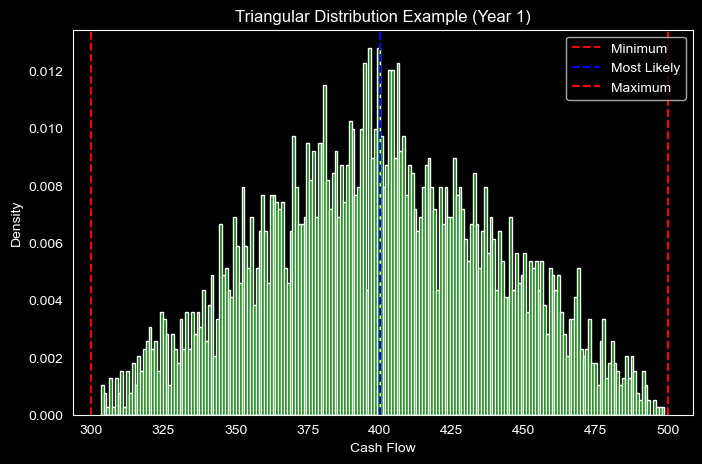

In [5]:
a1 = 300
m1 = 400
b1 = 500

samples = np.random.triangular(a1, m1, b1, size = 4000)

plt.figure(figsize=(8,5))
plt.hist(samples, bins=200, density=True, color="green")

plt.axvline(a1, linestyle="--", label = "Minimum", color = "red")
plt.axvline(m1, linestyle="--", label = "Most Likely", color = "blue")
plt.axvline(b1, linestyle="--", label = "Maximum", color = "red")

plt.title("Triangular Distribution Example (Year 1)")
plt.xlabel("Cash Flow")
plt.ylabel("Density")
plt.legend()
plt.grid(None)
plt.show()

### Why the histogram peak becomes clearer near the mode as sample size increases

A triangular distribution has a **mode** (most likely value), which is the point where its
probability density is highest.

A histogram is an **empirical estimator** of the distribution's Probability Density Function (PDF).
When the sample size \(n\) is small, the histogram is noisy: random sampling variation causes
some bins to be over- or under-represented.

As $(n)$ increases, the histogram becomes a more accurate approximation of the true PDF,
so the peak near the mode becomes clearer.

This can also be viewed through the lens of **error analysis / bias–variance tradeoff**:
- Small $(n)$ → high variance estimate ( noisy histogram )
- Large $(n)$ → lower variance estimate ( smoother histogram )

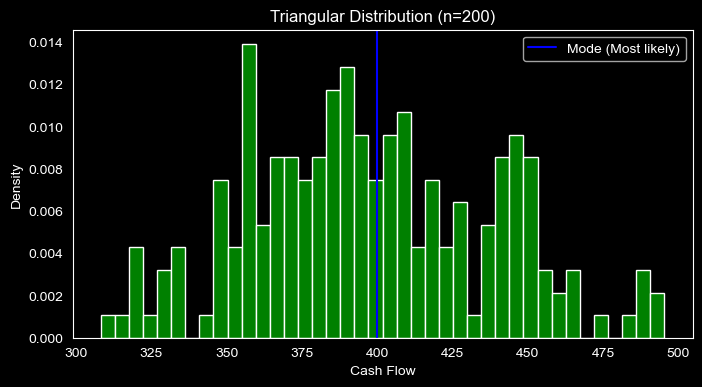

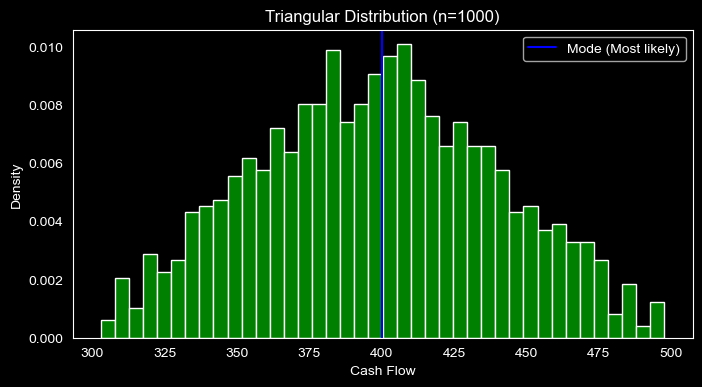

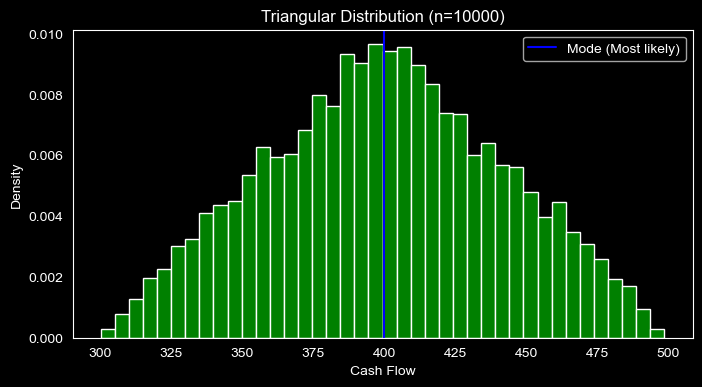

In [9]:
a1, m1, b1 = 300, 400, 500
sizes = [200, 1000, 10000]

for n in sizes:
    samples = np.random.triangular(a1, m1, b1, size=n)

    plt.figure(figsize=(8, 4))
    plt.hist(samples, bins=40, density=True, color="green")
    plt.axvline(m1, linestyle="-", label="Mode (Most likely)", color="blue")
    plt.title(f"Triangular Distribution (n={n})")
    plt.xlabel("Cash Flow")
    plt.ylabel("Density")
    plt.grid(None)
    plt.legend()
    plt.show()